In [62]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import random
import time
import math
import d2l
import os

from mxnet import autograd, np, npx, gluon, init, lr_scheduler
from mxnet.gluon import loss as gloss
from mxnet.gluon import rnn
from mxnet.gluon import nn
npx.set_np()

# 11. Optimization Algorithms
If you read the book in sequence up to this point you already used a number of advanced optimization algorithms to train deep learning models. They were the tools that allowed us to continue updating model parameters and to minimize the value of the loss function, as evaluated on the training set. Indeed, anyone content with treating optimization as a black box device to minimize objective functions in a simple setting might well content oneself with the knowledge that there exists an array of incantations of such a procedure (with names such as `Adam`, `NAG`, or `SGD`).

To do well, however, some deeper knowledge is required. Optimization algorithms are important for deep learning. On one hand, training a complex deep learning model can take hours, days, or even weeks. The performance of the optimization algorithm directly affects the model's training efficiency. On the other hand, understanding the principles of different optimization algorithms and the role of their parameters will enable us to tune the hyperparameters in a targeted manner to improve the performance of deep learning models.

In this chapter, we explore common deep learning optimization algorithms in depth. Almost all optimization problems arising in deep learning are nonconvex. Nonetheless, the design and analysis of algorithms in the context of convex problems has proven to be very instructive. It is for that reason that this section includes a primer on convex optimization and the proof for a very simple stochastic gradient descent algorithm on a convex objective function.

## 11.5 Minibatch Stochastic Gradient Descent
So far we encountered two extremes in the approach to gradient based learning: `Section 11.3` uses the full dataset to compute gradients and to update parameters, one pass at a time. Conversely `Section 11.4` processes one observation at a time to make progress. Each of them has its own drawbacks. Gradient Descent is not particularly data efficient whenever data is very similar. Stochastic Gradient Descent is not particularly computationally efficient since CPUs and GPUs cannot exploit the full power of vectorization. This suggests that there might be a happy medium, and in fact, that's what we have been using so far in the examples we discussed.

### 11.5.1 Vectorization and Caches
At the heart of the decision to use minibatches is computational efficiency. This is most easily understood when considering parallelization to multiple GPUs and multiple servers. In this case we need to send at least one image to each GPU. With 8 GPUs per server and 16 servers we already arrive at a minibatch size of 128.

Things are a bit more subtle when it comes to single GPUs or even CPUs. These devices have multiple types of memory, often multiple type of compute units and different bandwidth constraints between them. For instance, a CPU has a small number of registers and then $\textrm{L1}$, $\textrm{L2}$ and in some cases even $\textrm{L3}$ cache (which is shared between the different processor cores). These caches are of increasing size and latency (and at the same time they are of decreasing bandwidth). Suffice it to say, the processor is capable of performing many more operations than what the main memory interface is able to provide.

+ A 2GHz CPU with 16 cores and `AVX-512` vectorization can process up to $2 \cdot 10^9 \cdot 16 \cdot 32 = 10^{12}$ bytes per second. The capability of GPUs easily exceeds this number by a factor of 100. On the other hand, a midrange server processor might not have much more than 100 GB/s bandwidth, i.e., less than one tenth of what would be required to keep the processor fed. To make matters worse, not all memory access is created equal: first, memory interfaces are typically 64 bit wide or wider (e.g., on GPUs up to 384 bit), hence reading a single byte incurs the cost of a much wider access.

+ There is significant overhead for the first access whereas sequential access is relatively cheap (this is often called a burst read). There are many more things to keep in mind, such as caching when we have multiple sockets, chiplets and other structures. A detailed discussion of this is beyond the scope of this section. See e.g., this [Wikipedia article](https://en.wikipedia.org/wiki/Cache_hierarchy) for a more in-depth discussion.

The way to alleviate these constraints is to use a hierarchy of CPU caches which are actually fast enough to supply the processor with data. This is the driving force behind batching in deep learning. To keep matters simple, consider matrix-matrix multiplication, say $\mathbf{A} = \mathbf{B}\mathbf{C}$. We have a number of options for calculating $\mathbf{A}$. For instance we could try the following:
1. We could compute $\mathbf{A}_{ij} = \mathbf{B}_{i,:} \mathbf{C}_{:,j}^\top$, i.e., we could compute it element-wise by means of dot products.
2. We could compute $\mathbf{A}_{:,j} = \mathbf{B} \mathbf{C}_{:,j}^\top$, i.e., we could compute it one column at a time. Likewise we could compute $\mathbf{A}$ one row $\mathbf{A}_{i,:}$ at a time.
3. We could simply compute $\mathbf{A} = \mathbf{B} \mathbf{C}$.
4. We could break $\mathbf{B}$ and $\mathbf{C}$ into smaller block matrices and compute $\mathbf{A}$ one block at a time.

If we follow the first option, we will need to copy one row and one column vector into the CPU each time we want to compute an element $\mathbf{A}{ij}$. Even worse, due to the fact that matrix elements are aligned sequentially we are thus required to access many disjoint locations for one of the two vectors as we read them from memory. The second option is much more favorable. In it, we are able to keep the column vector $\mathbf{C}_{:,j}$ in the CPU cache while we keep on traversing through $B$. This halves the memory bandwidth requirement with correspondingly faster access. Of course, option 3 is most desirable. Unfortunately, most matrices might not entirely fit into cache (this is what we are discussing after all). However, option 4 offers a practically useful alternative: we can move blocks of the matrix into cache and multiply them locally. Optimized libraries take care of this for us. Let us have a look at how efficient these operations are in practice.

Beyond computational efficiency, the overhead introduced by Python and by the deep learning framework itself is considerable. Recall that each time we execute a command the Python interpreter sends a command to the `MXNet` engine which needs to insert it into the compute graph and deal with it during scheduling. Such overhead can be quite detrimental. In short, it is highly advisable to use vectorization (and matrices) whenever possible.

In [2]:
timer = d2l.Timer()
A = np.zeros((256, 256))
B = np.random.normal(0, 1, (256, 256))
C = np.random.normal(0, 1, (256, 256))

Element-wise assignment simply iterates over all rows and columns of $\mathbf{B}$ and $\mathbf{C}$ respectively to assign the value to $\mathbf{A}$.

In [3]:
# Compute A = BC one element at a time
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = np.dot(B[i, :], C[:, j])
A.wait_to_read()
timer.stop()

53.53671193122864

A faster strategy is to perform column-wise assignment.

In [4]:
# Compute A = BC one column at a time
timer.start()
for j in range(256):
    A[:, j] = np.dot(B, C[:, j])
A.wait_to_read()
timer.stop()

0.16601133346557617

Last, the most effective manner is to perform the entire operation in one block. Let us see what the respective speed of the operations is.

In [6]:
# Compute A = BC in one go
timer.start()
A = np.dot(B, C)
A.wait_to_read()
timer.stop()

0.0013003349304199219

In [7]:
# Multiply and add count as separate operations (fused in practice)
gigaflops = [2/i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 0.037, column 12.047, full 1404.892


### 11.5.2 Minibatches
In the past we took it for granted that we would read minibatches of data rather than single observations to update parameters. We now give a brief justification for it. Processing single observations requires us to perform many single matrix-vector (or even vector-vector) multiplications, which is quite expensive and which incurs a significant overhead on behalf of the underlying deep learning framework. This applies both to evaluating a network when applied to data (often referred to as inference) and when computing gradients to update parameters. That is, this applies whenever we perform $\mathbf{w} \leftarrow \mathbf{w} - \eta_t \mathbf{g}_t$ where

$$\mathbf{g}_t = \partial_{\mathbf{w}} f(\mathbf{x}_{t}, \mathbf{w})$$

We can increase the computational efficiency of this operation by applying it to a minibatch of observations at a time. That is, we replace the gradient $\mathbf{g}_t$ over a single observation by one over a small batch

$$\mathbf{g}_t = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w})$$

Let us see what this does to the statistical properties of $\mathbf{g}_t$: since both $\mathbf{x}_t$ and also all elements of the minibatch $\mathcal{B}_t$ are drawn uniformly at random from the training set, the expectation of the gradient remains unchanged. The variance, on the other hand, is reduced significantly. Since the minibatch gradient is composed of $b := |\mathcal{B}_t|$ independent gradients which are being averaged, its standard deviation is reduced by a factor of $\displaystyle b^{-\frac{1}{2}}$. This, by itself, is a good thing, since it means that the updates are more reliably aligned with the full gradient.

Naively this would indicate that choosing a large minibatch $\mathcal{B}_t$ would be universally desirable. Alas, after some point, the additional reduction in standard deviation is minimal when compared to the linear increase in computational cost. In practice we pick a minibatch that is large enough to offer good computational efficiency while still fitting into the memory of a GPU. To illustrate the savings let us have a look at some code. In it we perform the same matrix-matrix multiplication, but this time broken up into "minibatches" of 64 columns at a time.

In [8]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = np.dot(B, C[:, j:j+64])
timer.stop()

0.0034766197204589844

In [9]:
print(f'performance in Gigaflops: block {2 / timer.times[3]:.3f}')

performance in Gigaflops: block 1538.065


As we can see, the computation on the minibatch is essentially as efficient as on the full matrix. A word of caution is in order. In `Section 7.5` we used a type of regularization that was heavily dependent on the amount of variance in a minibatch. As we increase the latter, the variance decreases and with it the benefit of the noise-injection due to batch normalization. See e.g., (`Ioffe, 2017`) for details on how to rescale and compute the appropriate terms.

### 11.5.3 Reading the Dataset
Let us have a look at how minibatches are efficiently generated from data. In the following we use a dataset developed by `NASA` to test the wing noise from different aircraft to compare these optimization algorithms. For convenience we only use the first $1,500$ examples. The data is whitened for preprocessing, i.e., we remove the mean and rescale the variance to $1$ per coordinate.

In [10]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'), dtype=np.float32, delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]), batch_size, is_train=True)
    return data_iter, data.shape[1]-1

### 11.5.4 Implementation from Scratch
Recall the minibatch SGD implementation from `Section 3.2`. In the following we provide a slightly more general implementation. For convenience it has the same call signature as the other optimization algorithms introduced later in this chapter. Specifically, we add the status input states and place the hyperparameter in dictionary hyperparams. In addition, we will average the loss of each minibatch example in the training function, so the gradient in the optimization algorithm does not need to be divided by the batch size.

In [11]:
def sgd(params, states, hyperparams):
    for p in params:
        p[:] -= hyperparams['lr'] * p.grad

Next, we implement a generic training function to facilitate the use of the other optimization algorithms introduced later in this chapter. It initializes a linear regression model and can be used to train the model with minibatch SGD and other algorithms introduced subsequently.

In [12]:
#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter, feature_dim, num_epochs=2):
    # Initialization
    w = np.random.normal(scale=0.01, size=(feature_dim, 1))
    b = np.zeros(1)
    w.attach_grad()
    b.attach_grad()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # Train
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            with autograd.record():
                l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter), (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

Let us see how optimization proceeds for batch gradient descent. This can be achieved by setting the minibatch size to 1500 (i.e., to the total number of examples). As a result the model parameters are updated only once per epoch. There is little progress. In fact, after 6 steps progress stalls.

loss: 0.254, 0.070 sec/epoch


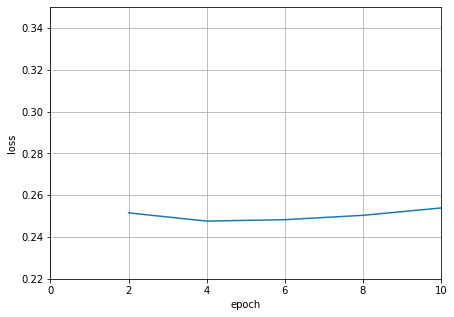

In [13]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

When the batch size equals 1, we use SGD for optimization. For simplicity of implementation we picked a constant (albeit small) learning rate. In SGD, the model parameters are updated whenever an example is processed. In our case this amounts to 1500 updates per epoch. As we can see, the decline in the value of the objective function slows down after one epoch. Although both the procedures processed 1500 examples within one epoch, SGD consumes more time than gradient descent in our experiment. This is because SGD updated the parameters more frequently and since it is less efficient to process single observations one at a time.

loss: 0.244, 0.336 sec/epoch


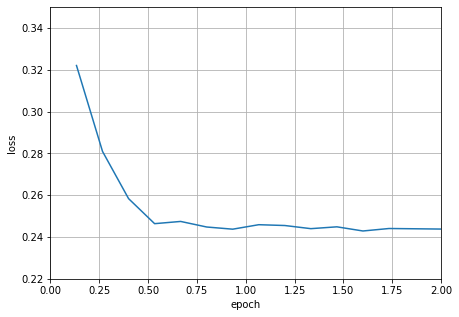

In [16]:
sgd_res = train_sgd(0.005, 1)

Last, when the batch size equals 100, we use minibatch SGD for optimization. The time required per epoch is shorter than the time needed for SGD and the time for batch gradient descent.

loss: 0.246, 0.008 sec/epoch


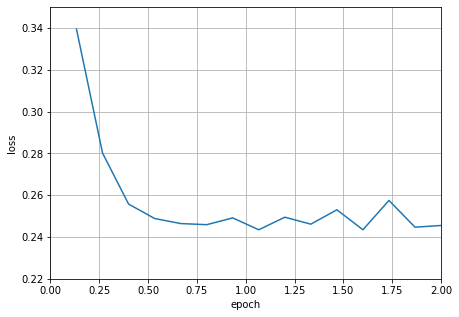

In [17]:
mini1_res = train_sgd(.4, 100)

Reducing the batch size to 10, the time for each epoch increases because the workload for each batch is less efficient to execute.

loss: 0.244, 0.037 sec/epoch


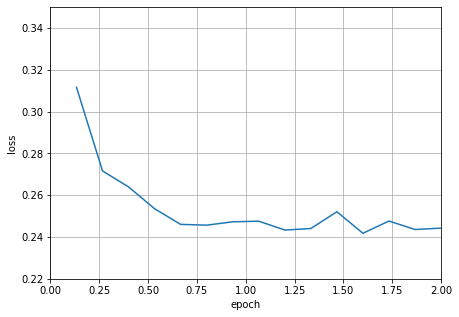

In [18]:
mini2_res = train_sgd(.05, 10)

Finally, we compare the time vs. loss for the preview four experiments. As can be seen, despite SGD converges faster than GD in terms of number of examples processed, it uses more time to reach the same loss than GD because that computing gradient example by example is not efficient. Minibatch SGD is able to trade-off the convergence speed and computation efficiency. A minibatch size 10 is more efficient than SGD; a minibatch size 100 even outperforms GD in terms of runtime.

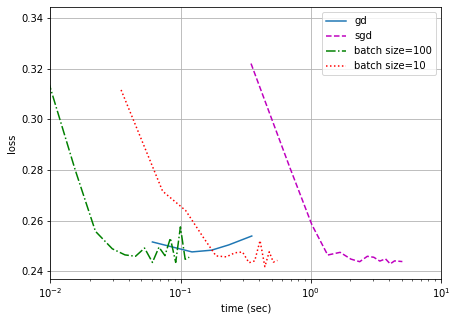

In [19]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

### 11.5.5 Concise Implementation
In `Gluon`, we can use the `Trainer` class to call optimization algorithms. This is used to implement a generic training function. We will use this throughout the current chapter.

In [20]:
#@save
def train_concise_ch11(tr_name, hyperparams, data_iter, num_epochs=2):
    # Initialization
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=0.01))
    trainer = gluon.Trainer(net.collect_params(), tr_name, hyperparams)
    loss = gluon.loss.L2Loss()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(X.shape[0])
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter), (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

Using `Gluon` to repeat the last experiment shows identical behavior.

loss: 0.244, 0.036 sec/epoch


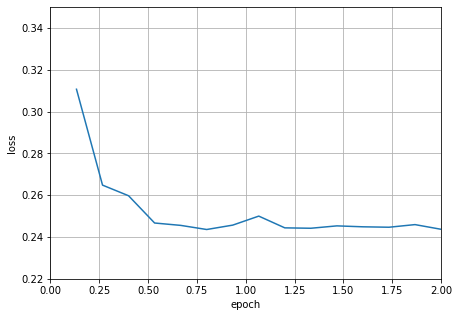

In [21]:
data_iter, _ = get_data_ch11(10)
train_concise_ch11('sgd', {'learning_rate': 0.05}, data_iter)

##### Summary
+ Vectorization makes code more efficient due to reduced overhead arising from the deep learning framework and due to better memory locality and caching on CPUs and GPUs.
+ There is a trade-off between statistical efficiency arising from SGD and computational efficiency arising from processing large batches of data at a time.
+ Minibatch stochastic gradient descent offers the best of both worlds: computational and statistical efficiency.
+ In minibatch SGD we process batches of data obtained by a random permutation of the training data (i.e., each observation is processed only once per epoch, albeit in random order).
+ It is advisable to decay the learning rates during training.
+ In general, minibatch SGD is faster than SGD and gradient descent for convergence to a smaller risk, when measured in terms of clock time.

##### Exercises
1. Modify the batch size and learning rate and observe the rate of decline for the value of the objective function and the time consumed in each epoch.
2. Read the MXNet documentation and use the Trainer class set_learning_rate function to reduce the learning rate of the minibatch SGD to 1/10 of its previous value after each epoch.
3. Compare minibatch SGD with a variant that actually samples with replacement from the training set. What happens?
4. An evil genie replicates your dataset without telling you (i.e., each observation occurs twice and your dataset grows to twice its original size, but nobody told you). How does the behavior of SGD, minibatch SGD and that of gradient descent change?


## 11.6 Momentum
In `Section 11.4` we reviewed what happens when performing stochastic gradient descent, i.e., when performing optimization where only a noisy variant of the gradient is available. In particular, we noticed that for noisy gradients we need to be extra cautious when it comes to choosing the learning rate in the face of noise. If we decrease it too rapidly, convergence stalls. If we are too lenient, we fail to converge to a good enough solution since noise keeps on driving us away from optimality.

### 11.6.1 Basics
In this section, we will explore more effective optimization algorithms, especially for certain types of optimization problems that are common in practice.

##### Leaky Averages
The previous section saw us discussing minibatch SGD as a means for accelerating computation. It also had the nice side-effect that averaging gradients reduced the amount of variance.

$$\mathbf{g}_t = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}_{t-1}) = \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} \mathbf{g}_{i, t-1}. $$

Here we used $\mathbf{g}_{ii} = \partial_{\mathbf{w}} f(\mathbf{x}_i, \mathbf{w}_t)$ to keep the notation simple. It would be nice if we could benefit from the effect of variance reduction even beyond averaging gradients on a mini-batch. One option to accomplish this task is to replace the gradient computation by a "leaky average":

$$\mathbf{v}_t = \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}$$

for some $\beta \in (0, 1)$. This effectively replaces the instantaneous gradient by one that's been averaged over multiple past gradients. $\mathbf{v}$ is called momentum. It accumulates past gradients similar to how a heavy ball rolling down the objective function landscape integrates over past forces. To see what is happening in more detail let us expand $\mathbf{v}_t$ recursively into

$$\begin{aligned} \displaystyle\mathbf{v}_t = \beta^2 \mathbf{v}_{t-2} + \beta \mathbf{g}_{t-1, t-2} + \mathbf{g}_{t, t-1} = \ldots, = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}. \end{aligned}$$

Large $\beta$ amounts to a long-range average, whereas small $\beta$ amounts to only a slight correction relative to a gradient method. The new gradient replacement no longer points into the direction of steepest descent on a particular instance any longer but rather in the direction of a weighted average of past gradients. This allows us to realize most of the benefits of averaging over a batch without the cost of actually computing the gradients on it. We will revisit this averaging procedure in more detail later.

The above reasoning formed the basis for what is now known as `accelerated` gradient methods, such as gradients with momentum. They enjoy the additional benefit of being much more effective in cases where the optimization problem is ill-conditioned (i.e., where there are some directions where progress is much slower than in others, resembling a narrow canyon). Furthermore, they allow us to average over subsequent gradients to obtain more stable directions of descent. Indeed, the aspect of acceleration even for noise-free convex problems is one of the key reasons why momentum works and why it works so well.

As one would expect, due to its efficacy momentum is a well-studied subject in optimization for deep learning and beyond. See e.g., the beautiful [expository article](https://distill.pub/2017/momentum/) by (`Goh, 2017`) for an in-depth analysis and interactive animation. It was proposed by (`Polyak, 1964`). (`Nesterov, 2018`) has a detailed theoretical discussion in the context of convex optimization. Momentum in deep learning has been known to be beneficial for a long time. See e.g., the discussion by (`Sutskever et al., 2013`) for details.

##### An Ill-conditioned Problem
To get a better understanding of the geometric properties of the momentum method we revisit gradient descent, albeit with a significantly less pleasant objective function. Recall that in `Section 11.3` we used $f(\mathbf{x}) = x_1^2 + 2 x_2^2$, i.e., a moderately distorted ellipsoid objective. We distort this function further by stretching it out in the $x_1$ direction via

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

As before $f$ has its minimum at $(0, 0)$. This function is very flat in the direction of $x_1$. Let us see what happens when we perform gradient descent as before on this new function. We pick a learning rate of $0.4$.

epoch 20, x1 -0.943467, x2 -0.000073


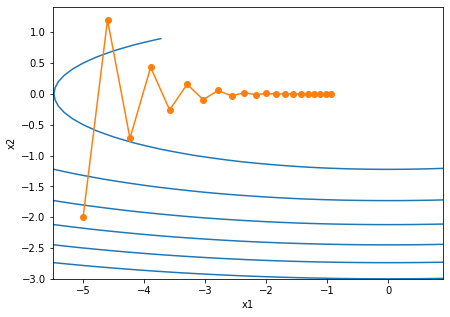

In [22]:
eta = 0.4

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

By construction, the gradient in the $x_2$ direction is much higher and changes much more rapidly than in the horizontal $x_1$ direction. Thus we are stuck between two undesirable choices: if we pick a small learning rate we ensure that the solution does not diverge in the $x_2$ direction but we are saddled with slow convergence in the $x_1$ direction. Conversely, with a large learning rate we progress rapidly in the $x_1$ direction but diverge in $x_2$. The example below illustrates what happens even after a slight increase in learning rate from $0.4$ to $0.6$. Convergence in the $x_1$ direction improves but the overall solution quality is much worse.

epoch 20, x1 -0.387814, x2 -1673.365109


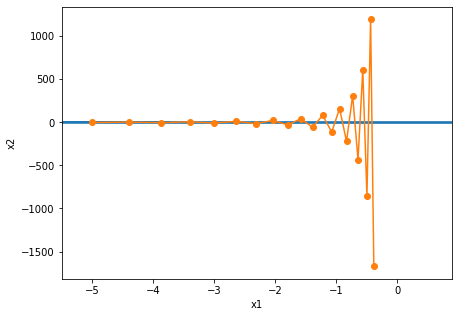

In [23]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

##### The Momentum Method
The momentum method allows us to solve the gradient descent problem described above. Looking at the optimization trace above we might intuit that averaging gradients over the past would work well. After all, in the $x_1$ direction this will aggregate well-aligned gradients, thus increasing the distance we cover with every step. Conversely, in the $x_2$ direction where gradients oscillate, an aggregate gradient will reduce step size due to oscillations that cancel each other out. Using $\mathbf{v}_t$ instead of the gradient $\mathbf{g}_t$ yields the following update equations:

$$\begin{aligned} \mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\ \mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t. \end{aligned} $$

Note that for $\beta = 0$ we recover regular gradient descent. Before delving deeper into the mathematical properties let us have a quick look at how the algorithm behaves in practice.

epoch 20, x1 0.007188, x2 0.002553


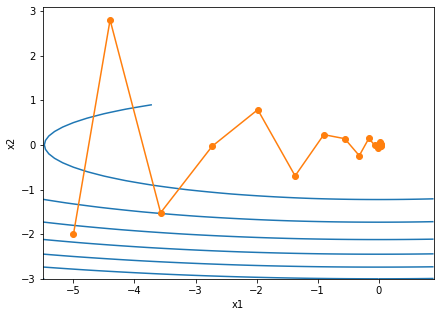

In [24]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

As we can see, even with the same learning rate that we used before, momentum still converges well. Let us see what happens when we decrease the momentum parameter. Halving it to $\beta = 0.25$ leads to a trajectory that barely converges at all. Nonetheless, it is a lot better than without momentum (when the solution diverges).

epoch 20, x1 -0.126340, x2 -0.186632


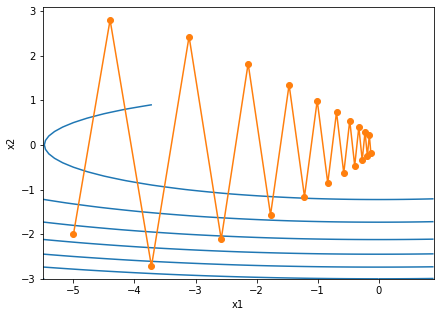

In [25]:
eta, beta = 0.6, 0.25
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

Note that we can combine momentum with SGD and in particular, minibatch-SGD. The only change is that in that case we replace the gradients $\mathbf{g}_{t, t-1}$ with $\mathbf{g}_t$. Last, for convenience we initialize $\mathbf{v}_0 = 0$ at time $t=0$. Let us look at what leaky averaging actually does to the updates.

##### Effective Sample Weight
Recall that $\mathbf{v}_t = \displaystyle\sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}$. In the limit the terms add up to $\displaystyle\sum_{\tau=0}^\infty \beta^\tau = \frac{1}{1-\beta}$. In other words, rather than taking a step of size $\eta$ in GD or SGD we take a step of size $\frac{\eta}{1-\beta}$ while at the same time, dealing with a potentially much better behaved descent direction. These are two benefits in one. To illustrate how weighting behaves for different choices of $\beta$ consider the diagram below.

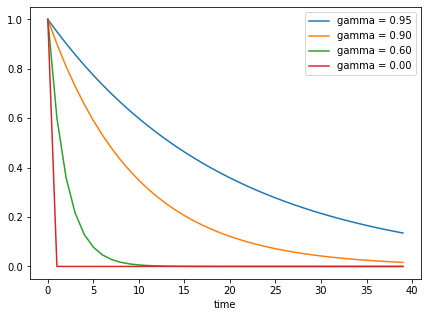

In [26]:
d2l.set_figsize()
gammas = [0.95, 0.9, 0.6, 0]
for gamma in gammas:
    x = np.arange(40).asnumpy()
    d2l.plt.plot(x, gamma ** x, label=f'gamma = {gamma:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

### 11.6.2 Practical Experiments
Let us see how momentum works in practice, i.e., when used within the context of a proper optimizer. For this we need a somewhat more scalable implementation.

##### Implementation from Scratch
Compared with (minibatch) SGD the momentum method needs to maintain a set of auxiliary variables, i.e., velocity. It has the same shape as the gradients (and variables of the optimization problem). In the implementation below we call these variables `states`.

In [27]:
def init_momentum_states(feature_dim):
    v_w = np.zeros((feature_dim, 1))
    v_b = np.zeros(1)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        v[:] = hyperparams['momentum'] * v + p.grad
        p[:] -= hyperparams['lr'] * v

Let us see how this works in practice.

loss: 0.243, 0.054 sec/epoch


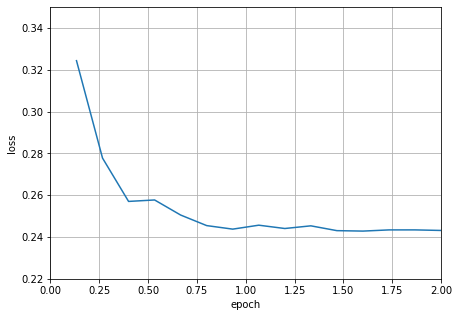

In [28]:
def train_momentum(lr, momentum, num_epochs=2):
    d2l.train_ch11(sgd_momentum, 
                   init_momentum_states(feature_dim),
                   {'lr': lr, 'momentum': momentum}, 
                   data_iter,
                   feature_dim, num_epochs)

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

When we increase the momentum hyperparameter momentum to 0.9, it amounts to a significantly larger effective sample size of $\frac{1}{1 - 0.9} = 10$. We reduce the learning rate slightly to $0.01$ to keep matters under control.

loss: 0.245, 0.053 sec/epoch


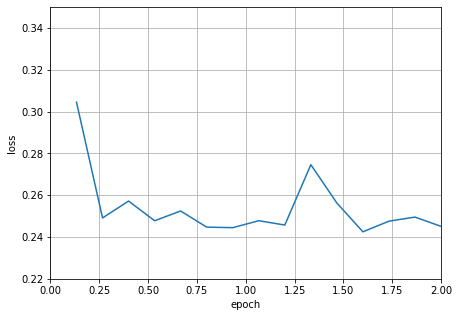

In [29]:
train_momentum(0.01, 0.9)

Reducing the learning rate further addresses any issue of non-smooth optimization problems. Setting it to $0.005$ yields good convergence properties.

loss: 0.244, 0.055 sec/epoch


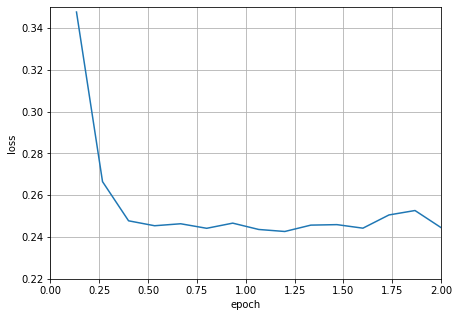

In [30]:
train_momentum(0.005, 0.9)

##### Concise Implementation
There is very little to do in `Gluon` since the standard sgd solver already had momentum built in. Setting matching parameters yields a very similar trajectory.

loss: 0.244, 0.035 sec/epoch


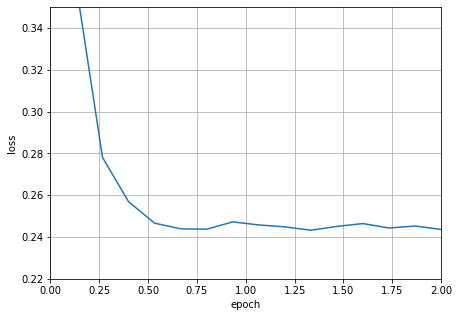

In [32]:
d2l.train_gluon_ch11('sgd', {'learning_rate': 0.005, 'momentum': 0.9}, data_iter)

### 11.6.3 Theoretical Analysis
So far the 2D example of $f(x) = 0.1 x_1^2 + 2 x_2^2$ seemed rather contrived. We will now see that this is actually quite representative of the types of problem one might encounter, at least in the case of minimizing convex quadratic objective functions.

##### Quadratic Convex Functions
Consider the function
$$h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b.$$

This is a general quadratic function. For positive semidefinite matrices $\mathbf{Q} \succ 0$, i.e., for matrices with positive eigenvalues this has a minimizer at $\mathbf{x}^* = -\mathbf{Q}^{-1} \mathbf{c}$ with minimum value $b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$. Hence we can rewrite $h$ as

$$h(\mathbf{x}) = \frac{1}{2} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})^\top \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c}) + b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}.$$

The gradient is given by $\partial_{\mathbf{x}} f(\mathbf{x}) = \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$. That is, it is given by the distance between $\mathbf{x}$ and the minimizer, multiplied by $\mathbf{Q}$. Consequently also the momentum is a linear combination of terms $\mathbf{Q} (\mathbf{x}_t - \mathbf{Q}^{-1} \mathbf{c})$.

Since $\mathbf{Q}$ is positive definite it can be decomposed into its eigensystem via $\mathbf{Q} = \mathbf{O}^\top \boldsymbol{\Lambda} \mathbf{O}$ for an orthogonal (rotation) matrix $\mathbf{O}$ and a diagonal matrix $\boldsymbol{\Lambda}$ of positive eigenvalues. This allows us to perform a change of variables from $\mathbf{x}$ to $\mathbf{z} := \mathbf{O} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$ to obtain a much simplified expression:

$$h(\mathbf{z}) = \frac{1}{2} \mathbf{z}^\top \boldsymbol{\Lambda} \mathbf{z} + b'.$$

Here $c' = b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$. Since $\mathbf{O}$ is only an orthogonal matrix this does not perturb the gradients in a meaningful way. Expressed in terms of $\mathbf{z}$ gradient descent becomes

$$\mathbf{z}t = \mathbf{z}{t-1} - \boldsymbol{\Lambda} \mathbf{z}{t-1} = (\mathbf{I} - \boldsymbol{\Lambda}) \mathbf{z}{t-1}.$$

The important fact in this expression is that gradient descent does not mix between different eigenspaces. That is, when expressed in terms of the eigensystem of $\mathbf{Q}$ the optimization problem proceeds in a coordinate-wise manner. This also holds for momentum.

$$\begin{aligned} \mathbf{v}t & = \beta \mathbf{v}{t-1} + \boldsymbol{\Lambda} \mathbf{z}{t-1} \ \mathbf{z}t & = \mathbf{z}{t-1} - \eta \left(\beta \mathbf{v}{t-1} + \boldsymbol{\Lambda} \mathbf{z}{t-1}\right) \ & = (\mathbf{I} - \eta \boldsymbol{\Lambda}) \mathbf{z}{t-1} - \eta \beta \mathbf{v}_{t-1}. \end{aligned}$$

In doing this we just proved the following theorem: Gradient Descent with and without momentum for a convex quadratic function decomposes into coordinate-wise optimization in the direction of the eigenvectors of the quadratic matrix.

##### Scalar Functions
Given the above result let us see what happens when we minimize the function $f(x) = \frac{\lambda}{2} x^2$. For gradient descent we have

$$x_{t+1} = x_t - \eta \lambda x_t = (1 - \eta \lambda) x_t.$$

Whenever $|1 - \eta \lambda| < 1$ this optimization converges at an exponential rate since after $t$ steps we have $x_t = (1 - \eta \lambda)^t x_0$. This shows how the rate of convergence improves initially as we increase the learning rate $\eta$ until $\eta \lambda = 1$. Beyond that things diverge and for $\eta \lambda > 2$ the optimization problem diverges.

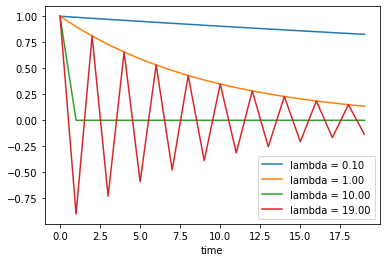

In [33]:
lambdas = [0.1, 1, 10, 19]
eta = 0.1
d2l.set_figsize((6, 4))
for lam in lambdas:
    t = np.arange(20).asnumpy()
    d2l.plt.plot(t, (1 - eta * lam) ** t, label=f'lambda = {lam:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

To analyze convergence in the case of momentum we begin by rewriting the update equations in terms of two scalars: one for $x$ and one for the momentum $v$. This yields:

$$ \begin{bmatrix} v_{t+1} \\ x_{t+1} \end{bmatrix} = \begin{bmatrix} \beta & \lambda \\ -\eta \beta & (1 - \eta \lambda) \end{bmatrix} \begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix} = \mathbf{R}(\beta, \eta, \lambda) \begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix}. $$

We used $\mathbf{R}$ to denote the $2 \times 2$ governing convergence behavior. After $t$ steps the initial choice $[v_0, x_0]$ becomes $\mathbf{R}(\beta, \eta, \lambda)^t [v_0, x_0]$. Hence, it is up to the eigenvalues of $\mathbf{R}$ to detmine the speed of convergence. See the [Distill post](https://distill.pub/2017/momentum/) of (`Goh, 2017`) for a great animation and (`Flammarion & Bach, 2015`) for a detailed analysis. One can show that $0 < \eta \lambda < 2 + 2 \beta$ momentum converges. This is a larger range of feasible parameters when compared to $0 < \eta \lambda < 2$ for gradient descent. It also suggests that in general large values of $\beta$ are desirable. Further details require a fair amount of technical detail and we suggest that the interested reader consult the original publications.

##### Summary
+ Momentum replaces gradients with a leaky average over past gradients. This accelerates convergence significantly.
+ It is desirable for both noise-free gradient descent and (noisy) stochastic gradient descent.
+ Momentum prevents stalling of the optimization process that is much more likely to occur for stochastic gradient descent.
+ The effective number of gradients is given by $\frac{1}{1-\beta}$ due to exponentiated downweighting of past data.
+ In the case of convex quadratic problems this can be analyzed explicitly in detail.
+ Implementation is quite straightforward but it requires us to store an additional state vector (momentum $\mathbf{v}$).

##### Exercises
1. Use other combinations of momentum hyperparameters and learning rates and observe and analyze the different experimental results.
2. Try out GD and momentum for a quadratic problem where you have multiple eigenvalues, i.e., $f(x) = \frac{1}{2} \sum_i \lambda_i x_i^2$, e.g., $\lambda_i = 2^{-i}$. Plot how the values of $x$ decrease for the initialization $x_i = 1$.
3. Derive minimum value and minimizer for $h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b$.
4. What changes when we perform SGD with momentum? What happens when we use mini-batch SGD with momentum? Experiment with the parameters?


## 11.7 Adagrad
Let us begin by considering learning problems with features that occur infrequently.

### 11.7.1 Sparse Features and Learning Rates
Imagine that we are training a language model. To get good accuracy we typically want to decrease the learning rate as we keep on training, usually at a rate of $\mathcal{O}(t^{-\frac{1}{2}})$ or slower. Now consider a model training on sparse features, i.e., features that occur only infrequently. This is common for natural language, e.g., it is a lot less likely that we will see the word preconditioning than learning. However, it is also common in other areas such as computational advertising and personalized collaborative filtering. After all, there are many things that are of interest only for a small number of people.

Parameters associated with infrequent features only receive meaningful updates whenever these features occur. Given a decreasing learning rate we might end up in a situation where the parameters for common features converge rather quickly to their optimal values, whereas for infrequent features we are still short of observing them sufficiently frequently before their optimal values can be determined. In other words, the learning rate either decreases too quickly for frequent features or too slowly for infrequent ones.

A possible hack to redress this issue would be to count the number of times we see a particular feature and to use this as a clock for adjusting learning rates. That is, rather than choosing a learning rate of the form $\eta = \displaystyle\frac{\eta_0}{\sqrt{t + c}}$ we could use $\eta_i = \displaystyle\frac{\eta_0}{\sqrt{s(i, t) + c}}$. Here $s(i, t)$ counts the number of nonzeros for feature $i$ that we have observed up to time $t$. This is actually quite easy to implement at no meaningful overhead. However, it fails whenever we do not quite have sparsity but rather just data where the gradients are often very small and only rarely large. After all, it is unclear where one would draw the line between something that qualifies as an observed feature or not.

Adagrad by (`Duchi et al., 2011`) addresses this by replacing the rather crude counter $s(i, t)$ by an aggregate of the squares of previously observed gradients. In particular, it uses $s(i, t+1) = s(i, t) + \left(\partial_i f(\mathbf{x})\right)^2$ as a means to adjust the learning rate. This has two benefits: first, we no longer need to decide just when a gradient is large enough. Second, it scales automatically with the magnitude of the gradients. Coordinates that routinely correspond to large gradients are scaled down significantly, whereas others with small gradients receive a much more gentle treatment. In practice this leads to a very effective optimization procedure for computational advertising and related problems. But this hides some of the additional benefits inherent in Adagrad that are best understood in the context of preconditioning.

### 11.7.2 Preconditioning
Convex optimization problems are good for analyzing the characteristics of algorithms. After all, for most nonconvex problems it is difficult to derive meaningful theoretical guarantees, but intuition and insight often carry over. Let us look at the problem of minimizing $f(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{c}^\top \mathbf{x} + b$.

As we saw in `Section 11.6`, it is possible to rewrite this problem in terms of its eigendecomposition $\mathbf{Q} = \mathbf{U}^\top \boldsymbol{\Lambda} \mathbf{U}$ to arrive at a much simplified problem where each coordinate can be solved individually:

$$f(\mathbf{x}) = \bar{f}(\bar{\mathbf{x}}) = \frac{1}{2} \bar{\mathbf{x}}^\top \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}}^\top \bar{\mathbf{x}} + b.$$

Here we used $\mathbf{x} = \mathbf{U} \mathbf{x}$ and consequently $\mathbf{c} = \mathbf{U} \mathbf{c}$. The modified problem has as its minimizer $\bar{\mathbf{x}} = -\boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}}$ and minimum value $-\frac{1}{2} \bar{\mathbf{c}}^\top \boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}} + b$. This is much easier to compute since $\boldsymbol{\Lambda}$ is a diagonal matrix containing the eigenvalues of $\mathbf{Q}$.

If we perturb $\mathbf{c}$ slightly we would hope to find only slight changes in the minimizer of $f$. Unfortunately this is not the case. While slight changes in $\mathbf{c}$ lead to equally slight changes in $\bar{\mathbf{c}}$, this is not the case for the minimizer of $f$ (and of $\bar{f}$ respectively). Whenever the eigenvalues $\boldsymbol{\Lambda}_i$ are large we will see only small changes in $\bar{x}_i$ and in the minimum of $\bar{f}$. Conversely, for small $\boldsymbol{\Lambda}_i$ changes in $\bar{x}_i$ can be dramatic. The ratio between the largest and the smallest eigenvalue is called the condition number of an optimization problem.

$$\kappa = \frac{\boldsymbol{\Lambda}_1}{\boldsymbol{\Lambda}_d}.$$

If the condition number $\kappa$ is large, it is difficult to solve the optimization problem accurately. We need to ensure that we are careful in getting a large dynamic range of values right. Our analysis leads to an obvious, albeit somewhat naive question: couldn't we simply "fix" the problem by distorting the space such that all eigenvalues are $1$. In theory this is quite easy: we only need the eigenvalues and eigenvectors of $\mathbf{Q}$ to rescale the problem from $\mathbf{x}$ to one in $\mathbf{z} := \boldsymbol{\Lambda}^{\frac{1}{2}} \mathbf{U} \mathbf{x}$. In the new coordinate system $\mathbf{x}^\top \mathbf{Q} \mathbf{x}$ could be simplified to $|\mathbf{z}|^2$. Alas, this is a rather impractical suggestion. Computing eigenvalues and eigenvectors is in general much more expensive than solving the actual problem.

While computing eigenvalues exactly might be expensive, guessing them and computing them even somewhat approximately may already be a lot better than not doing anything at all. In particular, we could use the diagonal entries of $\mathbf{Q}$ and rescale it accordingly. This is much cheaper than computing eigenvalues.

$$\tilde{\mathbf{Q}} = \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q}) \mathbf{Q} \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q}).$$

In this case we have $\tilde{\mathbf{Q}}{ij} = \mathbf{Q}{ij} / \sqrt{\mathbf{Q}{ii} \mathbf{Q}{jj}}$ and specifically $\tilde{\mathbf{Q}}_{ii} = 1$ for all $i$. In most cases this simplifies the condition number considerably. For instance, the cases we discussed previously, this would entirely eliminate the problem at hand since the problem is axis aligned.

Unfortunately we face yet another problem: in deep learning we typically do not even have access to the second derivative of the objective function: for $\mathbf{x} \in \mathbb{R}^d$ the second derivative even on a minibatch may require $\mathcal{O}(d^2)$ space and work to compute, thus making it practically infeasible. The ingenious idea of Adagrad is to use a proxy for that elusive diagonal of the Hessian that is both relatively cheap to compute and effective---the magnitude of the gradient itself.

In order to see why this works, let us look at $\bar{f}(\bar{\mathbf{x}})$. We have that

$$\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}}) = \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}} = \boldsymbol{\Lambda} \left(\bar{\mathbf{x}} - \bar{\mathbf{x}}_0\right),$$

where $\bar{\mathbf{x}}_0$ is the minimizer of $\bar{f}$. Hence the magnitude of the gradient depends both on $\boldsymbol{\Lambda}$ and the distance from optimality. If $\bar{\mathbf{x}} - \bar{\mathbf{x}}0$ didn't change, this would be all that's needed. After all, in this case the magnitude of the gradient $\partial{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}})$ suffices. Since AdaGrad is a stochastic gradient descent algorithm, we will see gradients with nonzero variance even at optimality. As a result we can safely use the variance of the gradients as a cheap proxy for the scale of the Hessian. A thorough analysis is beyond the scope of this section (it would be several pages). We refer the reader to (`Duchi et al., 2011`) for details.

### 11.7.3 The Algorithm
Let us formalize the discussion from above. We use the variable $\mathbf{s}_t$ to accumulate past gradient variance as follows.

$$\begin{aligned} \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\ \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\ \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t. \end{aligned}$$

Here the operation are applied coordinate wise. That is, $\mathbf{v}^2$ has entries $v_i^2$. Likewise $\frac{1}{\sqrt{v}}$ has entries $\frac{1}{\sqrt{v_i}}$ and $\mathbf{u} \cdot \mathbf{v}$ has entries $u_i v_i$. As before $\eta$ is the learning rate and $\epsilon$ is an additive constant that ensures that we do not divide by $0$. Last, we initialize $\mathbf{s}_0 = \mathbf{0}$.

Just like in the case of momentum we need to keep track of an auxiliary variable, in this case to allow for an individual learning rate per coordinate. This does not increase the cost of Adagrad significantly relative to SGD, simply since the main cost is typically to compute $l(y_t, f(\mathbf{x}_t, \mathbf{w}))$ and its derivative.

Note that accumulating squared gradients in $\mathbf{s}_t$ means that $\mathbf{s}_t$ grows essentially at linear rate (somewhat slower than linearly in practice, since the gradients initially diminish). This leads to an $\mathcal{O}(t^{-\frac{1}{2}})$ learning rate, albeit adjusted on a per coordinate basis. For convex problems this is perfectly adequate. In deep learning, though, we might want to decrease the learning rate rather more slowly. This led to a number of Adagrad variants that we will discuss in the subsequent chapters. For now let us see how it behaves in a quadratic convex problem. We use the same problem as before:

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

We are going to implement Adagrad using the same learning rate previously, i.e., $\eta = 0.4$. As we can see, the iterative trajectory of the independent variable is smoother. However, due to the cumulative effect of $\boldsymbol{s}_t$, the learning rate continuously decays, so the independent variable does not move as much during later stages of iteration.

epoch 20, x1 -2.382563, x2 -0.158591


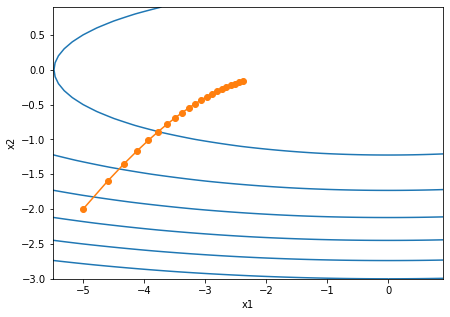

In [34]:
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

As we increase the learning rate to $2$ we see much better behavior. This already indicates that the decrease in learning rate might be rather aggressive, even in the noise-free case and we need to ensure that parameters converge appropriately.

epoch 20, x1 -0.002295, x2 -0.000000


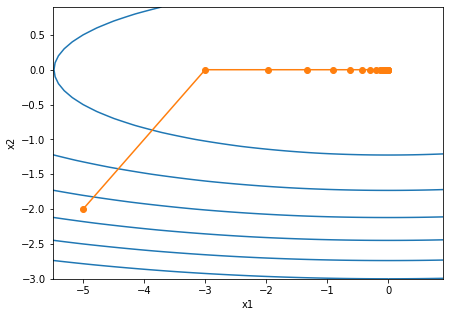

In [35]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

### 11.7.4 Implementation from Scratch
Just like the momentum method, Adagrad needs to maintain a state variable of the same shape as the parameters.

In [36]:
def init_adagrad_states(feature_dim):
    s_w = np.zeros((feature_dim, 1))
    s_b = np.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        s[:] += np.square(p.grad)
        p[:] -= hyperparams['lr'] * p.grad / np.sqrt(s + eps)

Compared to the experiment in `Section 11.5` we use a larger learning rate to train the model.

loss: 0.242, 0.055 sec/epoch


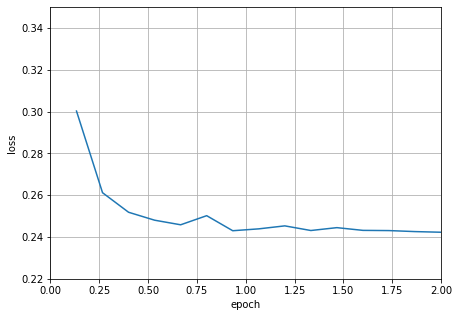

In [37]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim), {'lr': 0.1}, data_iter, feature_dim);

### 11.7.5 Concise Implementation
Using the `Trainer` instance of the algorithm adagrad, we can invoke the `Adagrad` algorithm in `Gluon`.

loss: 0.243, 0.063 sec/epoch


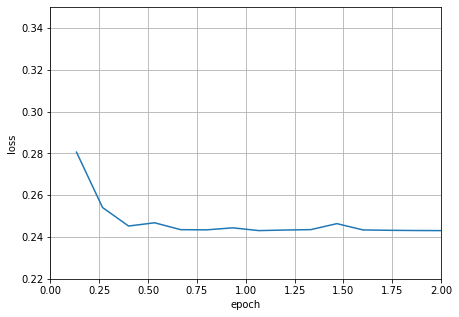

In [39]:
d2l.train_gluon_ch11('adagrad', {'learning_rate': 0.1}, data_iter)

##### Summary
+ Adagrad decreases the learning rate dynamically on a per-coordinate basis.
+ It uses the magnitude of the gradient as a means of adjusting how quickly progress is achieved - coordinates with large gradients are compensated with a smaller learning rate.
+ Computing the exact second derivative is typically infeasible in deep learning problems due to memory and computational constraints. The gradient can be a useful proxy.
+ If the optimization problem has a rather uneven uneven structure Adagrad can help mitigate the distortion.
+ Adagrad is particularly effective for sparse features where the learning rate needs to decrease more slowly for infrequently occurring terms.
+ On deep learning problems Adagrad can sometimes be too aggressive in reducing learning rates. We will discuss strategies for mitigating this in the context of `Section 11.10`.

##### Exercises
1. Prove that for an orthogonal matrix $\mathbf{U}$ and a vector $\mathbf{c}$ the following holds: $|\mathbf{c} - \mathbf{\delta}|_2 = |\mathbf{U} \mathbf{c} - \mathbf{U} \mathbf{\delta}|_2$. Why does this mean that the magnitude of perturbations does not change after an orthogonal change of variables?
2. Try out Adagrad for $f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2$ and also for the objective function was rotated by 45 degrees, i.e., $f(\mathbf{x}) = 0.1 (x_1 + x_2)^2 + 2 (x_1 - x_2)^2$. Does it behave differently?
3. Prove Gerschgorin's circle theorem which states that eigenvalues $\lambda_i$ of a matrix $\mathbf{M}$ satisfy $|\lambda_i - \mathbf{M}{jj}| \leq \sum{k \neq j} |\mathbf{M}_{jk}|$ for at least one choice of $j$.
4. What does Gerschgorin's theorem tell us about the eigenvalues of the diagonally preconditioned matrix $\mathrm{diag}^{-\frac{1}{2}}(\mathbf{M}) \mathbf{M} \mathrm{diag}^{-\frac{1}{2}}(\mathbf{M})$?
5. Try out Adagrad for a proper deep network, such as `Section 6.6` when applied to Fashion MNIST.
6. How would you need to modify Adagrad to achieve a less aggressive decay in learning rate?


## 11.8 RMSProp
One of the key issues in `Section 11.7` is that the learning rate decreases at a predefined schedule of effectively $\mathcal{O}(t^{-\frac{1}{2}})$. While this is generally appropriate for convex problems, it might not be ideal for nonconvex ones, such as those encountered in deep learning. Yet, the coordinate-wise adaptivity of Adagrad is highly desirable as a preconditioner.

(`Tieleman & Hinton, 2012`) proposed the RMSProp algorithm as a simple fix to decouple rate scheduling from coordinate-adaptive learning rates. The issue is that Adagrad accumulates the squares of the gradient $\mathbf{g}_t$ into a state vector $\mathbf{s}t = \mathbf{s}_{t-1} + \mathbf{g}_t^2$. As a result $\mathbf{s}_t$ keeps on growing without bound due to the lack of normalization, essentially linarly as the algorithm converges.

One way of fixing this problem would be to use $\mathbf{s}_t / t$. For reasonable distributions of $\mathbf{g}_t$ this will converge. Unfortunately it might take a very long time until the limit behavior starts to matter since the procedure remembers the full trajectory of values. An alternative is to use a leaky average in the same way we used in the momentum method, i.e., $\mathbf{s}_t \leftarrow \gamma \mathbf{s}_{t-1} + (1-\gamma) \mathbf{g}_t^2$ for some parameter $\gamma > 0$. Keeping all other parts unchanged yields RMSProp.

### 11.8.1 The Algorithm
Let us write out the equations in detail.

$$\begin{aligned} \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\ \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t. \end{aligned}$$

The constant $\epsilon > 0$ is typically set to $10^{-6}$ to ensure that we do not suffer from division by zero or overly large step sizes. Given this expansion we are now free to control the learning rate $\eta$ independently of the scaling that is applied on a per-coordinate basis. In terms of leaky averages we can apply the same reasoning as previously applied in the case of the momentum method. Expanding the definition of $\mathbf{s}_t$ yields

$$ \begin{aligned} \mathbf{s}_t & = (1 - \gamma) \mathbf{g}_t^2 + \gamma \mathbf{s}_{t-1} \\ & = (1 - \gamma) \left(\mathbf{g}_t^2 + \gamma \mathbf{g}_{t-1}^2 + \gamma^2 \mathbf{g}_{t-2} + \ldots, \right). \end{aligned} $$

As before in `Section 11.6` we use $1 + \gamma + \gamma^2 + \ldots, = \frac{1}{1-\gamma}$. Hence the sum of weights is normalized to $1$ with a half-life time of an observation of $\gamma^{-1}$. Let us visualize the weights for the past 40 timesteps for various choices of $\gamma$.

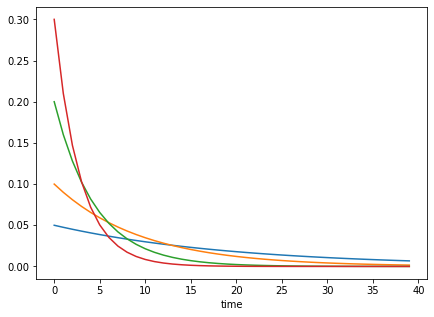

In [40]:
d2l.set_figsize()
gammas = [0.95, 0.9, 0.8, 0.7]
for gamma in gammas:
    x = np.arange(40).asnumpy()
    d2l.plt.plot(x, (1-gamma) * gamma ** x, label=f'gamma = {gamma:.2f}')
d2l.plt.xlabel('time');

### 11.8.2 Implementation from Scratch
As before we use the quadratic function $f(\mathbf{x})=0.1x_1^2+2x_2^2$ to observe the trajectory of RMSProp. Recall that in `Section 11.7`, when we used Adagrad with a learning rate of 0.4, the variables moved only very slowly in the later stages of the algorithm since the learning rate decreased too quickly. Since $\eta$ is controlled separately this does not happen with RMSProp.

epoch 20, x1 -0.010599, x2 0.000000


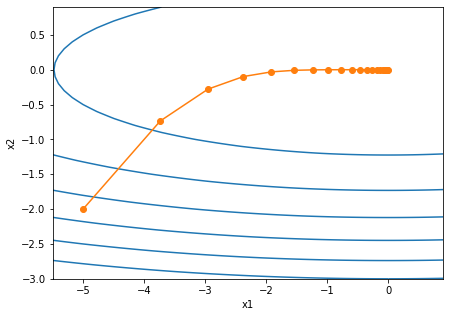

In [41]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

Next, we implement RMSProp to be used in a deep network. This is equally straightforward.

In [42]:
def init_rmsprop_states(feature_dim):
    s_w = np.zeros((feature_dim, 1))
    s_b = np.zeros(1)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        s[:] = gamma * s + (1 - gamma) * np.square(p.grad)
        p[:] -= hyperparams['lr'] * p.grad / np.sqrt(s + eps)

We set the initial learning rate to 0.01 and the weighting term $\gamma$ to 0.9. That is, $\mathbf{s}$ aggregates on average over the past $1/(1-\gamma) = 10$ observations of the square gradient.

loss: 0.243, 0.065 sec/epoch


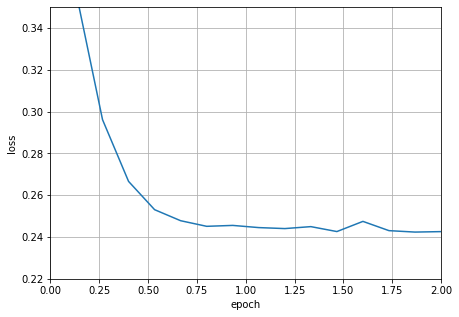

In [43]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

### 11.8.3 Concise Implementation
Since RMSProp is a rather popular algorithm it is also available in the `Trainer` instance. All we need to do is instantiate it using an algorithm named `rmsprop`, assigning $\gamma$ to the parameter `gamma1`.

loss: 0.242, 0.037 sec/epoch


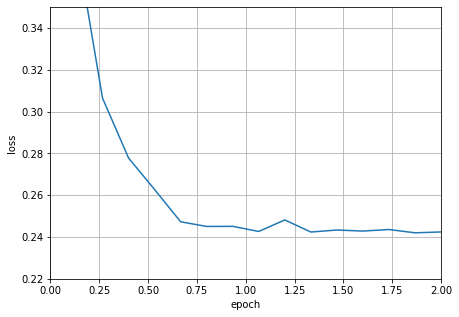

In [44]:
d2l.train_gluon_ch11('rmsprop', {'learning_rate': 0.01, 'gamma1': 0.9}, data_iter)

##### Summary
+ RMSProp is very similar to Adagrad insofar as both use the square of the gradient to scale coefficients.
+ RMSProp shares with momentum the leaky averaging. However, RMSProp uses the technique to adjust the coefficient-wise preconditioner.
+ The learning rate needs to be scheduled by the experimenter in practice.
+ The coefficient $\gamma$ determines how long the history is when adjusting the per-coordinate scale.

##### Exercises
1. What happens experimentally if we set $\gamma = 1$? Why?
2. Rotate the optimization problem to minimize $f(\mathbf{x}) = 0.1 (x_1 + x_2)^2 + 2 (x_1 - x_2)^2$. What happens to the convergence?
3. Try out what happens to RMSProp on a real machine learning problem, such as training on Fashion-MNIST. Experiment with different choices for adjusting the learning rate.
4. Would you want to adjust $\gamma$ as optimization progresses? How sensitive is RMSProp to this?


## 11.9 Adadelta
Adadelta is yet another variant of AdaGrad. The main difference lies in the fact that it decreases the amount by which the learning rate is adaptive to coordinates. Moreover, traditionally it referred to as not having a learning rate since it uses the amount of change itself as calibration for future change. The algorithm was proposed in (`Zeiler, 2012`). It is fairly straightforward, given the discussion of previous algorithms so far.

### 11.9.1 The Algorithm
In a nutshell Adadelta uses two state variables, $\mathbf{s}_t$ to store a leaky average of the second moment of the gradient and $\Delta\mathbf{x}_t$ to store a leaky average of the second moment of the change of parameters in the model itself. Note that we use the original notation and naming of the authors for compatibility with other publications and implementations (there is no other real reason why one should use different Greek variables to indicate a parameter serving the same purpose in momentum, Adagrad, RMSProp, and Adadelta). The parameter du jour is $\rho$. We obtain the following leaky updates:

$$\begin{aligned} \mathbf{s}_t & = \rho \mathbf{s}_{t-1} + (1 - \rho) \mathbf{g}_t^2, \\ \mathbf{g}_t' & = \sqrt{\frac{\Delta\mathbf{x}_{t-1} + \epsilon}{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t, \\ \mathbf{x}_t & = \mathbf{x}_{t-1} - \mathbf{g}_t', \\ \Delta \mathbf{x}_t & = \rho \Delta\mathbf{x}_{t-1} + (1 - \rho) \mathbf{x}_t^2. \end{aligned}$$

The difference to before is that we perform updates with the rescaled gradient $\mathbf{g}_t'$ which is computed by taking the ratio between the average squared rate of change and the average second moment of the gradient. The use of $\mathbf{g}_t'$ is purely for notational convenience. In practice we can implement this algorithm without the need to use additional temporary space for $\mathbf{g}_t'$. As before $\eta$ is a parameter ensuring nontrivial numerical results, i.e., avoiding zero step size or infinite variance. Typically we set this to $\eta = 10^{-5}$.

### 11.9.2 Implementation
Adadelta needs to maintain two state variables for each variable, $\mathbf{s}_t$ and $\Delta\mathbf{x}_t$. This yields the following implementation.

In [45]:
def init_adadelta_states(feature_dim):
    s_w, s_b = np.zeros((feature_dim, 1)), np.zeros(1)
    delta_w, delta_b = np.zeros((feature_dim, 1)), np.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        # In-place updates via [:]
        s[:] = rho * s + (1 - rho) * np.square(p.grad)
        g = (np.sqrt(delta + eps) / np.sqrt(s + eps)) * p.grad
        p[:] -= g
        delta[:] = rho * delta + (1 - rho) * g * g

Choosing $\rho = 0.9$ amounts to a half-life time of 10 for each parameter update. This tends to work quite well. We get the following behavior.

loss: 0.243, 0.087 sec/epoch


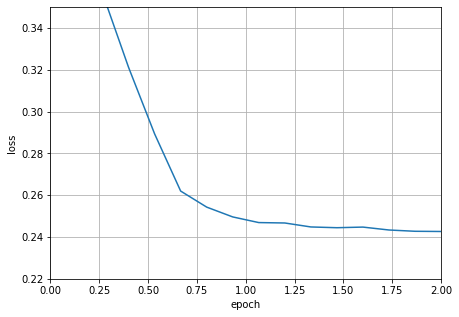

In [46]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim);

For a concise implementation we simply use the adadelta algorithm from the `Trainer` class. This yields the following one-liner for a much more compact invocation.

loss: 0.243, 0.089 sec/epoch


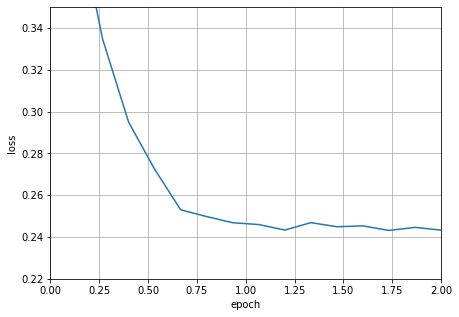

In [48]:
d2l.train_gluon_ch11('adadelta', {'rho': 0.9}, data_iter)

##### Summary
+ Adadelta has no learning rate parameter. Instead, it uses the rate of change in the parameters itself to adapt the learning rate.
+ Adadelta requires two state variables to store the second moments of gradient and the change in parameters.
+ Adadelta uses leaky averages to keep a running estimate of the appropriate statistics.

##### Exercises
1. Adjust the value of $\rho$. What happens?
2. Show how to implement the algorithm without the use of $\mathbf{g}_t'$. Why might this be a good idea?
3. Is Adadelta really learning rate free? Could you find optimization problems that break Adadelta?
4. Compare Adadelta to Adagrad and RMS prop to discuss their convergence behavior.


## 11.10 Adam
In the discussions leading up to this section we encountered a number of techniques for efficient optimization. Let us recap them in detail here:
+ We saw that `Section 11.4` is more effective than Gradient Descent when solving optimization problems, e.g., due to its inherent resilience to redundant data.
+ We saw that `Section 11.5` affords significant additional efficiency arising from vectorization, using larger sets of observations in one minibatch. This is the key to efficient multi-machine, multi-GPU and overall parallel processing.
+ `Section 11.6` added a mechanism for aggregating a history of past gradients to accelerate convergence.
+ `Section 11.7` used per-coordinate scaling to allow for a computationally efficient preconditioner.
+ `Section 11.8` decoupled per-coordinate scaling from a learning rate adjustment.

Adam (`Kingma & Ba, 2014`) combines all these techniques into one efficient learning algorithm. As expected, this is an algorithm that has become rather popular as one of the more robust and effective optimization algorithms to use in deep learning. It is not without issues, though. In particular, (`Reddi et al., 2019`) show that there are situations where Adam can diverge due to poor variance control. In a follow-up work (`Zaheer et al., 2018`) proposed a hotfix to Adam, called Yogi which addresses these issues. More on this later. For now let us review the Adam algorithm.

### 11.10.1 The Algorithm
One of the key components of Adam is that it uses exponential weighted moving averages (also known as leaky averaging) to obtain an estimate of both the momentum and also the second moment of the gradient. That is, it uses the state variables

$$\begin{aligned} \mathbf{v}_t & \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t, \\ \mathbf{s}_t & \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2. \end{aligned}$$

Here $\beta_1$ and $\beta_2$ are nonnegative weighting parameters. Common choices for them are $\beta_1 = 0.9$ and $\beta_2 = 0.999$. That is, the variance estimate moves much more slowly than the momentum term. Note that if we initialize $\mathbf{v}_0 = \mathbf{s}0 = 0$ we have a significant amount of bias initially towards smaller values. This can be addressed by using the fact that $\sum{i=0}^t \beta^i = \frac{1 - \beta^t}{1 - \beta}$ to re-normalize terms. Correspondingly the normalized state variables are given by

$$\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \text{ and } \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}.$$

Armed with the proper estimates we can now write out the update equations. First, we rescale the gradient in a manner very much akin to that of RMSProp to obtain

$$\mathbf{g}_t' = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}.$$

Unlike RMSProp our update uses the momentum $\hat{\mathbf{v}}_t$ rather than the gradient itself. Moreover, there is a slight cosmetic difference as the rescaling happens using $\frac{1}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}$ instead of $\frac{1}{\sqrt{\hat{\mathbf{s}}_t + \epsilon}}$. The former works arguably slightly better in practice, hence the deviation from RMSProp. Typically we pick $\epsilon = 10^{-6}$ for a good trade-off between numerical stability and fidelity.

Now we have all the pieces in place to compute updates. This is slightly anticlimactic and we have a simple update of the form

$$\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g}_t'.$$

Reviewing the design of Adam its inspiration is clear. Momentum and scale are clearly visible in the state variables. Their rather peculiar definition forces us to debias terms (this could be fixed by a slightly different initialization and update condition). Second, the combination of both terms is pretty straightforward, given RMSProp. Last, the explicit learning rate $\eta$ allows us to control the step length to address issues of convergence.

### 11.10.2 Implementation
Implementing Adam from scratch is not very daunting. For convenience we store the timestep counter $t$ in the hyperparams dictionary. Beyond that all is straightforward.

In [49]:
def init_adam_states(feature_dim):
    v_w, v_b = np.zeros((feature_dim, 1)), np.zeros(1)
    s_w, s_b = np.zeros((feature_dim, 1)), np.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        v[:] = beta1 * v + (1 - beta1) * p.grad
        s[:] = beta2 * s + (1 - beta2) * np.square(p.grad)
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        p[:] -= hyperparams['lr'] * v_bias_corr / (np.sqrt(s_bias_corr) + eps)
    hyperparams['t'] += 1

We are ready to use Adam to train the model. We use a learning rate of $\eta = 0.01$.

loss: 0.244, 0.087 sec/epoch


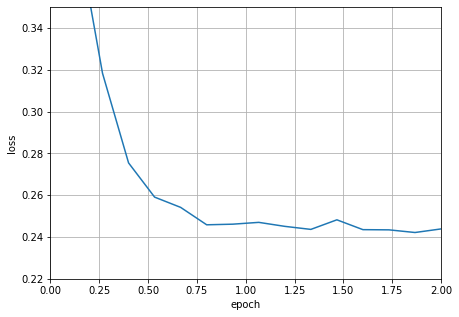

In [50]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

A more concise implementation is straightforward since adam is one of the algorithms provided as part of the `Gluon` trainer optimization library. Hence we only need to pass configuration parameters for an implementation in `Gluon`.

loss: 0.244, 0.039 sec/epoch


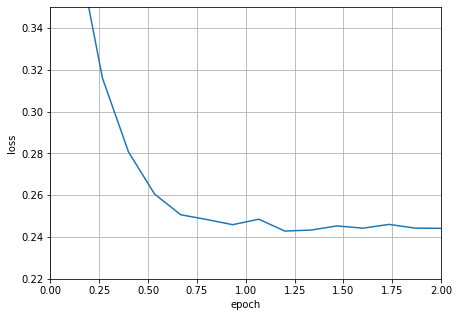

In [51]:
d2l.train_gluon_ch11('adam', {'learning_rate': 0.01}, data_iter)

### 11.10.3 Yogi
One of the problems of Adam is that it can fail to converge even in convex settings when the second moment estimate in $\mathbf{s}_t$ blows up. As a fix (`Zaheer et al., 2018`) proposed a refined update (and initialization) for $\mathbf{s}_t$. To understand what's going on, let us rewrite the Adam update as follows:

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \left(\mathbf{g}_t^2 - \mathbf{s}_{t-1}\right).$$

Whenever $\mathbf{g}_t^2$ has high variance or updates are sparse, $\mathbf{s}_t$ might forget past values too quickly. A possible fix for this is to replace $\mathbf{g}_t^2 - \mathbf{s}_{t-1}$ by $\mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1})$. Now the magnitude of the update no longer depends on the amount of deviation. This yields the Yogi updates

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1}).$$

The authors furthermore advise to initialize the momentum on a larger initial batch rather than just initial pointwise estimate. We omit the details since they are not material to the discussion and since even without this convergence remains pretty good.

loss: 0.244, 0.094 sec/epoch


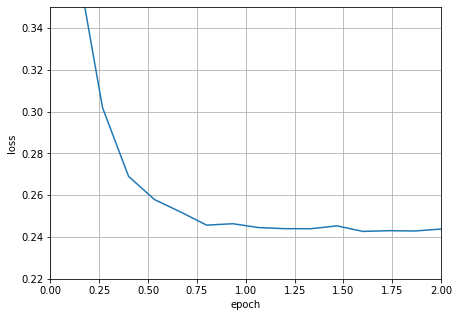

In [52]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        v[:] = beta1 * v + (1 - beta1) * p.grad
        s[:] = s + (1 - beta2) * np.sign(
            np.square(p.grad) - s) * np.square(p.grad)
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        p[:] -= hyperparams['lr'] * v_bias_corr / (np.sqrt(s_bias_corr) + eps)
    hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(yogi, init_adam_states(feature_dim), {'lr': 0.01, 't': 1}, data_iter, feature_dim);

##### Summary
+ Adam combines features of many optimization algorithms into a fairly robust update rule.
+ Created on the basis of RMSProp, Adam also uses EWMA on the minibatch stochastic gradient
+ Adam uses bias correction to adjust for a slow startup when estimating momentum and a second moment.
+ For gradients with significant variance we may encounter issues with convergence. They can be amended by using larger minibatches or by switching to an improved estimate for $\mathbf{s}_t$. Yogi offers such an alternative.

##### Exercises
1. Adjust the learning rate and observe and analyze the experimental results.
2. Can you rewrite momentum and second moment updates such that it does not require bias correction?
3. Why do you need to reduce the learning rate $\eta$ as we converge?
4. Try to construct a case for which Adam diverges and Yogi converges?


## 11.11 Learning Rate Scheduling
So far we primarily focused on optimization algorithms for how to update the weight vectors rather than on the rate at which they are being updated. Nonetheless, adjusting the learning rate is often just as important as the actual algorithm. There are a number of aspects to consider:
+ Most obviously the magnitude of the learning rate matters. If it is too large, optimization diverges, if it is too small, it takes too long to train or we end up with a suboptimal result. We saw previously that the condition number of the problem matters (see e.g., `Section 11.6` for details). Intuitively it is the ratio of the amount of change in the least sensitive direction vs. the most sensitive one.
+ Secondly, the rate of decay is just as important. If the learning rate remains large we may simply end up bouncing around the minimum and thus not reach optimality. `Section 11.5` discussed this in some detail and we analyzed performance guarantees in `Section 11.4`. In short, we want the rate to decay, but probably more slowly than $\mathcal{O}(t^{-\frac{1}{2}})$ which would be a good choice for convex problems.
+ Another aspect that is equally important is initialization. This pertains both to how the parameters are set initially (review `Section 4.8` for details) and also how they evolve initially. This goes under the moniker of warmup, i.e., how rapidly we start moving towards the solution initially. Large steps in the beginning might not be beneficial, in particular since the initial set of parameters is random. The initial update directions might be quite meaningless, too.
+ Lastly, there are a number of optimization variants that perform cyclical learning rate adjustment. This is beyond the scope of the current chapter. We recommend the reader to review details in (`Izmailov et al., 2018`), e.g., how to obtain better solutions by averaging over an entire *path* of parameters.

Given the fact that there is a lot of detail needed to manage learning rates, most deep learning frameworks have tools to deal with this automatically. In the current chapter we will review the effects that different schedules have on accuracy and also show how this can be managed efficiently via a *learning rate scheduler*.

### 11.11.1 Toy Problem
We begin with a toy problem that is cheap enough to compute easily, yet sufficiently nontrivial to illustrate some of the key aspects. For that we pick a slightly modernized version of `LeNet` (`relu` instead of `sigmoid` activation, `MaxPooling` rather than `AveragePooling`), as applied to `Fashion-MNIST`. Moreover, we hybridize the network for performance. Since most of the code is standard we just introduce the basics without further detailed discussion. See `Chapter 6` for a refresher as needed.

In [54]:
net = nn.HybridSequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Dense(120, activation='relu'),
        nn.Dense(84, activation='relu'),
        nn.Dense(10))
net.hybridize()
loss = gluon.loss.SoftmaxCrossEntropyLoss()
ctx = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# The code is almost identical to `d2l.train_ch6` that defined in the lenet
# section of chapter convolutional neural networks
def train(net, train_iter, test_iter, num_epochs, loss, trainer, ctx):
    net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs], 
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            X, y = X.as_in_ctx(ctx), y.as_in_ctx(ctx)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter), (train_loss, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

Let us have a look at what happens if we invoke this algorithm with default settings, such as a learning rate of $0.3$ and train for $30$ iterations. Note how the training accuracy keeps on increasing while progress in terms of test accuracy stalls beyond a point. The gap between both curves indicates overfitting.

train loss 0.183, train acc 0.929, test acc 0.873


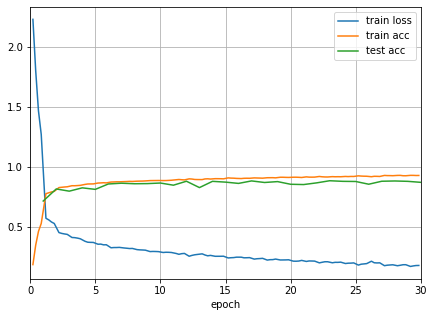

In [55]:
lr, num_epochs = 0.3, 30
net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
train(net, train_iter, test_iter, num_epochs, loss, trainer, ctx)

### 11.11.2 Schedulers
One way of adjusting the learning rate is to set it explicitly at each step. This is conveniently achieved by the `set_learning_rate` method. We could adjust it downward after every epoch (or even after every minibatch), e.g., in a dynamic manner in response to how optimization is progressing.

In [56]:
trainer.set_learning_rate(0.1)
print(f'learning rate is now {trainer.learning_rate:.2f}')

learning rate is now 0.10


More generally we want to define a scheduler. When invoked with the number of updates it returns the appropriate value of the learning rate. Let us define a simple one that sets the learning rate to $\eta = \eta_0 (t + 1)^{-\frac{1}{2}}$.

In [57]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

Let us plot its behavior over a range of values.

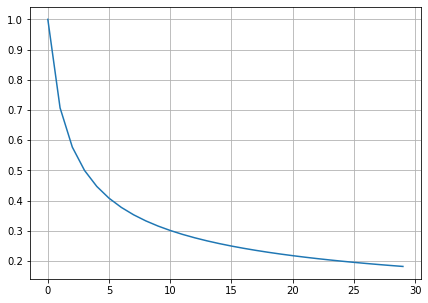

In [58]:
scheduler = SquareRootScheduler(lr=1.0)
d2l.plot(np.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

Now let us see how this plays out for training on `Fashion-MNIST`. We simply provide the scheduler as an additional argument to the training algorithm.

train loss 0.296, train acc 0.894, test acc 0.875


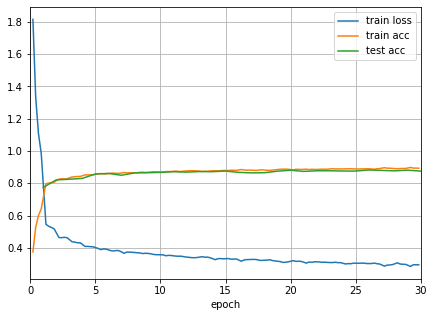

In [59]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'lr_scheduler': scheduler})
train(net, train_iter, test_iter, num_epochs, loss, trainer, ctx)

This worked quite a bit better than previously. Two things stand out: the curve was rather more smooth than previously. Secondly, there was less overfitting. Unfortunately it is not a well-resolved question as to why certain strategies lead to less overfitting in theory. There is some argument that a smaller stepsize will lead to parameters that are closer to zero and thus simpler. However, this does not explain the phenomenon entirely since we do not really stop early but simply reduce the learning rate gently.

### 11.11.3 Policies
While we cannot possibly cover the entire variety of learning rate schedulers, we attempt to give a brief overview of popular policies below. Common choices are `polynomial decay` and `piecewise constant schedules`. Beyond that, `cosine learning rate schedules` have been found to work well empirically on some problems. Lastly, on some problems it is beneficial to warm up the optimizer prior to using large learning rates.

##### Factor Scheduler
One alternative to a polynomial decay would be a multiplicative one, that is $\eta_{t+1} \leftarrow \eta_t \cdot \alpha$ for $\alpha \in (0, 1)$. To prevent the learning rate from decaying beyond a reasonable lower bound the update equation is often modified to $\eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha)$.

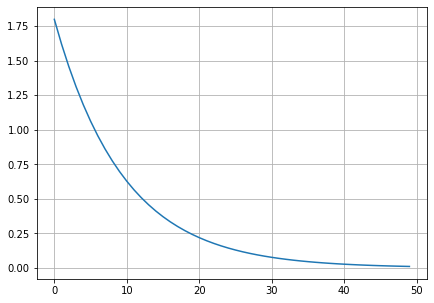

In [60]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(np.arange(50), [scheduler(t) for t in range(50)])

This can also be accomplished by a built-in scheduler in `MXNet` via the `lr_scheduler.FactorScheduler` object. It takes a few more parameters, such as warmup period, warmup mode (linear or constant), the maximum number of desired updates, etc.; Going forward we will use the built-in schedulers as appropriate and only explain their functionality here. As illustrated, it is fairly straightforward to build your own scheduler if needed.

##### Multi Factor Scheduler
A common strategy for training deep networks is to keep the learning rate piecewise constant and to decrease it by a given amount every so often. That is, given a set of times when to decrease the rate, such as $s = \{5, 10, 20\}$ decrease $\eta_{t+1} \leftarrow \eta_t \cdot \alpha$ whenever $t \in s$. Assuming that the values are halved at each step we can implement this as follows.

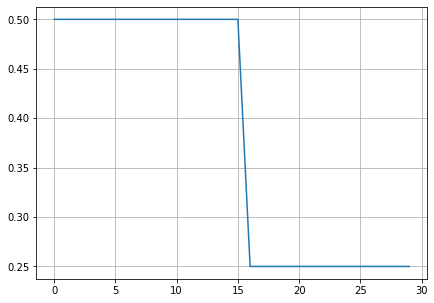

In [63]:
scheduler = lr_scheduler.MultiFactorScheduler(step=[15, 30], factor=0.5, base_lr=0.5)
d2l.plot(np.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

The intuition behind this piecewise constant learning rate schedule is that one lets optimization proceed until a stationary point has been reached in terms of the distribution of weight vectors. Then (and only then) do we decrease the rate such as to obtain a higher quality proxy to a good local minimum. The example below shows how this can produce ever slightly better solutions.

train loss 0.180, train acc 0.933, test acc 0.906


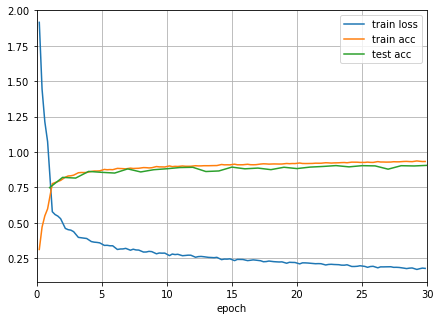

In [64]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'lr_scheduler': scheduler})
train(net, train_iter, test_iter, num_epochs, loss, trainer, ctx)

##### Cosine Scheduler
A rather perplexing heuristic was proposed by (`Loshchilov & Hutter, 2016`). It relies on the observation that we might not want to decrease the learning rate too drastically in the beginning and moreover, that we might want to "refine" the solution in the end using a very small learning rate. This results in a cosine-like schedule with the following functional form for learning rates in the range $t \in [0, T]$.

$$\eta_t = \eta_T + \frac{\eta_0 - \eta_T}{2} \left(1 + \cos(\pi t/T)\right)$$

Here $\eta_0$ is the initial learning rate, $\eta_T$ is the target rate at time $T$. Furthermore, for $t > T$ we simply pin the value to $\eta_T$ without increasing it again. In the following example, we set the max update step $T = 20$.

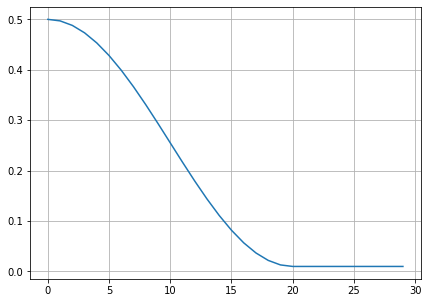

In [65]:
scheduler = lr_scheduler.CosineScheduler(max_update=20, base_lr=0.5, final_lr=0.01)
d2l.plot(np.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

In the context of computer vision this schedule can lead to improved results. Note, though, that such improvements are not guaranteed (as can be seen below).

train loss 0.355, train acc 0.872, test acc 0.874


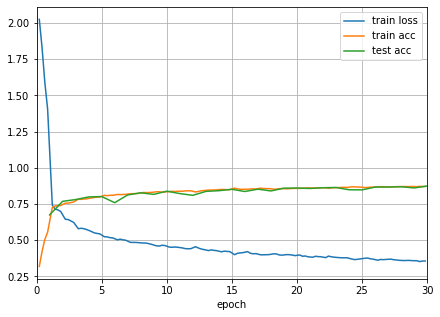

In [66]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'lr_scheduler': scheduler})
train(net, train_iter, test_iter, num_epochs, loss, trainer, ctx)

##### Warmup
In some cases initializing the parameters is not sufficient to guarantee a good solution. This particularly a problem for some advanced network designs that may lead to unstable optimization problems. We could address this by choosing a sufficiently small learning rate to prevent divergence in the beginning. Unfortunately this means that progress is slow. Conversely, a large learning rate initially leads to divergence.

A rather simple fix for this dilemma is to use a warmup period during which the learning rate increases to its initial maximum and to cool down the rate until the end of the optimization process. For simplicity one typically uses a linear increase for this purpose. This leads to a schedule of the form indicated below.

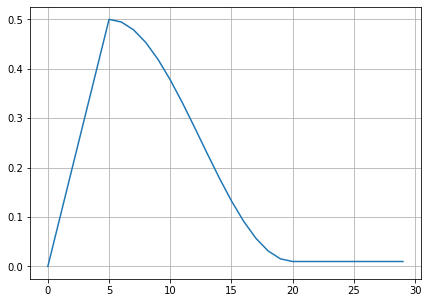

In [67]:
scheduler = lr_scheduler.CosineScheduler(20, warmup_steps=5, base_lr=0.5, final_lr=0.01)
d2l.plot(np.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

Note that the network converges better initially (in particular observe the performance during the first 5 epochs).

train loss 0.377, train acc 0.864, test acc 0.864


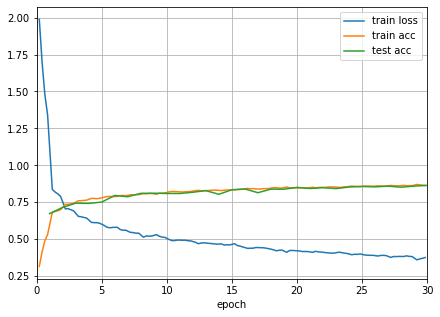

In [68]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'lr_scheduler': scheduler})
train(net, train_iter, test_iter, num_epochs, loss, trainer, ctx)

Warmup can be applied to any scheduler (not just cosine). For a more detailed discussion of learning rate schedules and many more experiments see also (`Gotmare et al., 2018`). In particular they find that a warmup phase limits the amount of divergence of parameters in very deep networks. This makes intuitively sense since we would expect significant divergence due to random initialization in those parts of the network that take the most time to make progress in the beginning.

##### Summary
+ Decreasing the learning rate during training can lead to improved accuracy and (most perplexingly) reduced overfitting of the model.
+ A piecewise decrease of the learning rate whenever progress has plateaued is effective in practice. Essentially this ensures that we converge efficiently to a suitable solution and only then reduce the inherent variance of the parameters by reducing the learning rate.
+ Cosine schedulers are popular for some computer vision problems. See e.g., `GluonCV` for details of such a scheduler.
+ A warmup period before optimization can prevent divergence.
+ Optimization serves multiple purposes in deep learning. Besides minimizing the training objective, different choices of optimization algorithms and learning rate scheduling can lead to rather different amounts of generalization and overfitting on the test set (for the same amount of training error).

##### Exercises
1. Experiment with the optimization behavior for a given fixed learning rate. What is the best model you can obtain this way?
2. How does convergence change if you change the exponent of the decrease in the learning rate? Use `PolyScheduler` for your convenience in the experiments.
3. Apply the cosine scheduler to large computer vision problems, e.g., training `ImageNet`. How does it affect performance relative to other schedulers?
4. How long should warmup last?
5. Can you connect optimization and sampling? Start by using results from (`Welling & Teh, 2011`) on Stochastic Gradient Langevin Dynamics.